In [1]:
# import necessary modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from evaluation import test
from utils import load_data, predict_image, scatter_plot, contour_plot
from utils import plot_boundary, load_cat_dataset, load_iris_2D
from utils import plot_costs, construct_polynomial_feats, plot_curve

from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
# from lr import LogisticRegression
from lm import LinearRegression, Ridge, SGDRegressor

We've seen how to implement linear regression step by step. Now let's see what we can do with our learning algorithm.

Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5, where the groundtruth function is just a linear function (i.e., only require polynomial features up to degree 1).

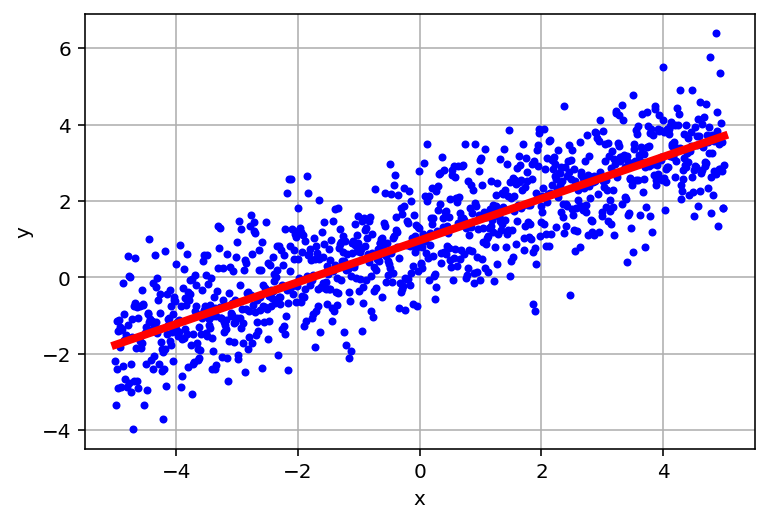

In [2]:
POLY_DEGREE = 5
NUM_OBS = 1000
# random generator
rng = np.random.RandomState(seed=4)
true_weight = rng.rand(POLY_DEGREE + 1, 1)
true_weight[2:, :] = 0
x_all = np.linspace(-5, 5, NUM_OBS)
x_all_feat = construct_polynomial_feats(x_all, POLY_DEGREE)
# in the second term, we add noise to data
y_all = np.dot(x_all_feat, true_weight) + rng.randn(x_all_feat.shape[0], 1) 
# Note that here we try to produce y_all as our training data
plot_curve(x_all, y_all) # Data with noise that we are going to predict
# the groundtruth information
plot_curve(x_all, np.dot(x_all_feat, true_weight), curve_type='-', color='r', lw=4)
indices = rng.permutation(NUM_OBS)

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy observations. The observations are generated by $Y = XW + \sigma$, where $\sigma \sim \mathcal{N}(0, 1)$ are i.i.d. generated noise. 

Now let's split the data into two parts, namely the training set and test set. The red dots are for training, while the blue dots are for testing.

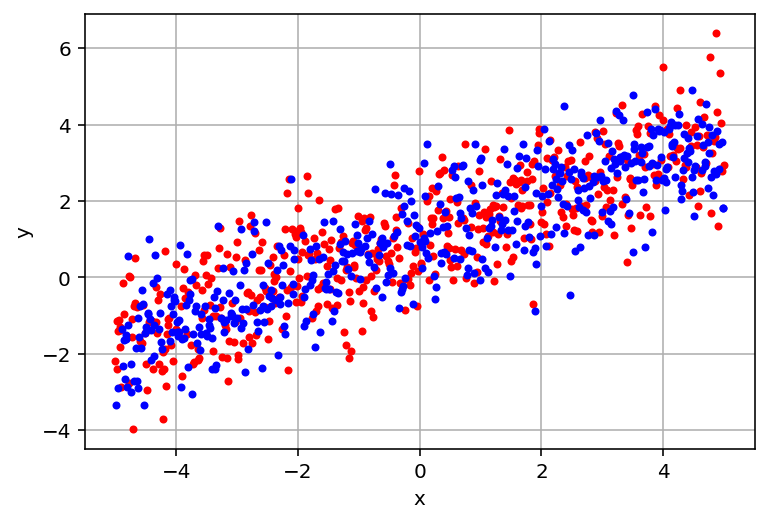

In [3]:
#helper, do not need to change

train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

plot_curve(x_all[train_indices], y_all[train_indices], color='r')
plot_curve(x_all[test_indices], y_all[test_indices], color='b')

Now let's first train using the entire training set, and see how we performs on the test set and how the learned function look like. We remove the first feature from the training set so that we can correctly implement regularization.

In [4]:
# remove the first feature so we can apply
# l2 regularization correctly
x_all_feat = x_all_feat[:,1:]
x_all_feat.shape

(1000, 6)

(1000, 5)

First let's see how it performs on the whole dataset.

In [5]:
reg = LinearRegression()
reg.fit(x_all_feat[train_indices], y_all[train_indices])

y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

LinearRegression(c_lambda=0, fit_intercept=True, penalty=None)

test rmse: 0.9222


Compare with batch gradient descent.

In [6]:
reg = SGDRegressor(batch=True, learning_rate=1e-7, max_iter=500000)
reg.fit(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

SGDRegressor(batch=True, c_lambda=0, fit_intercept=True, learning_rate=1e-07,
             max_iter=500000, penalty=None)

test rmse: 1.1695


Plot the cost in iterations.

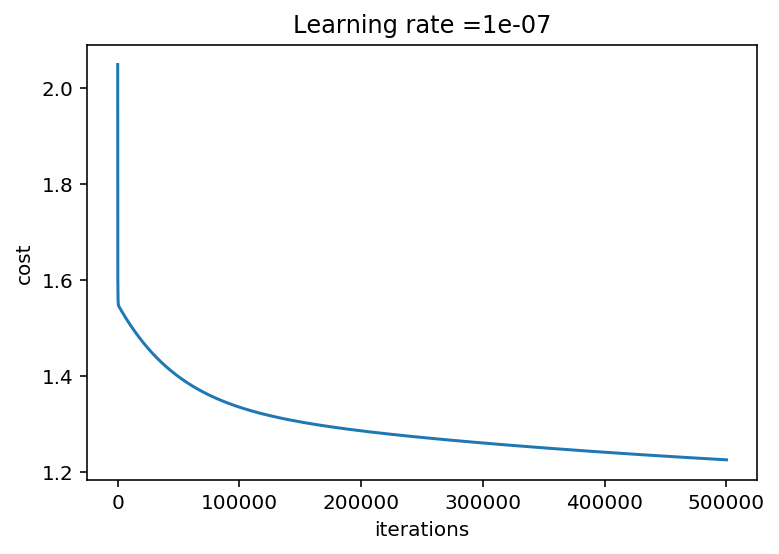

In [7]:
plot_costs(reg)

Test linear regression with stochastic gradient descent

In [8]:
reg = SGDRegressor(batch=False, learning_rate=1e-7, max_iter=2500)
reg.fit(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

SGDRegressor(batch=False, c_lambda=0, fit_intercept=True, learning_rate=1e-07,
             max_iter=2500, penalty=None)

test rmse: 1.1695


We achieved similar performance with fewer iterations.

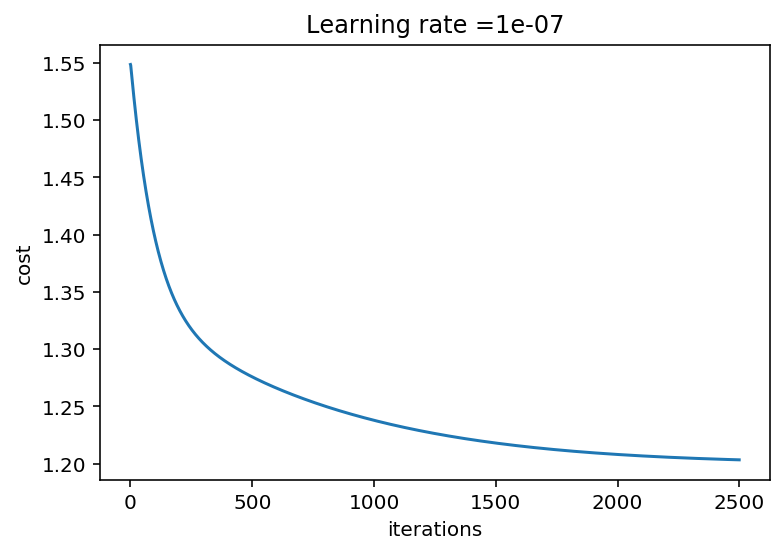

In [9]:
plot_costs(reg)

And what if we just use the first 10 observations to train? 

In [10]:
sub_train = train_indices[:10]
reg = LinearRegression()
reg.fit(x_all_feat[sub_train], y_all[sub_train])
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse))

LinearRegression(c_lambda=0, fit_intercept=True, penalty=None)

test rmse: 2.1910


Did you see a worse performance? Let's take a closer look at what we have learned.

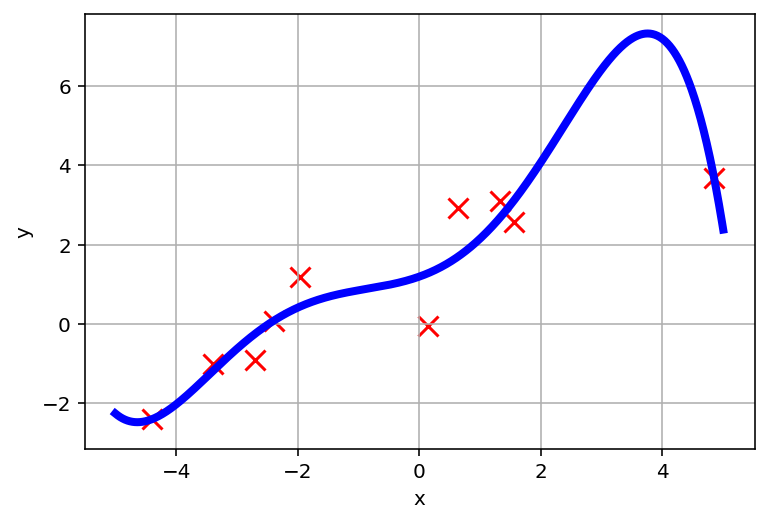

In [11]:
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred, curve_type='-', color='b', lw=4)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x');

We can apply l2 regularization to the model so it can generelize well on testing data. First let's see how l2 perform on normal equation linear regression.

test rmse: 1.2115


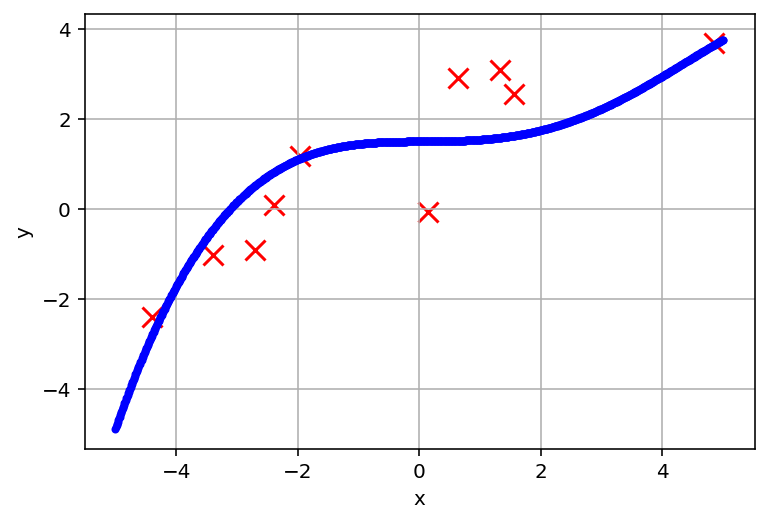

In [12]:
reg = LinearRegression(penalty='l2', c_lambda=1000)
reg.fit(x_all_feat[sub_train],  y_all[sub_train])
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse));

Apply l2 regularization to stochastic gradient descent linear regression.

test rmse: 1.6673


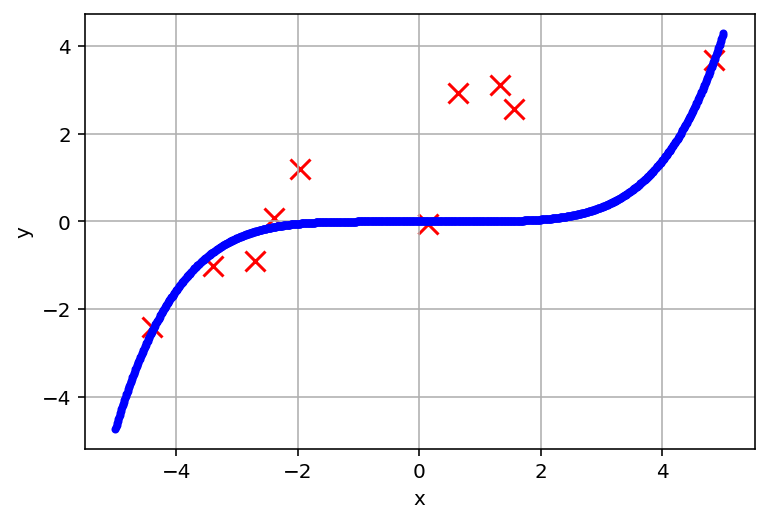

In [13]:
reg = SGDRegressor(batch=False, learning_rate=1e-7, max_iter=100, c_lambda=1000, penalty='l2')
reg.fit(x_all_feat[sub_train], y_all[sub_train])
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse));

Apply l2 regularization on linear regression with batch gradient descent.

test rmse: 1.6446


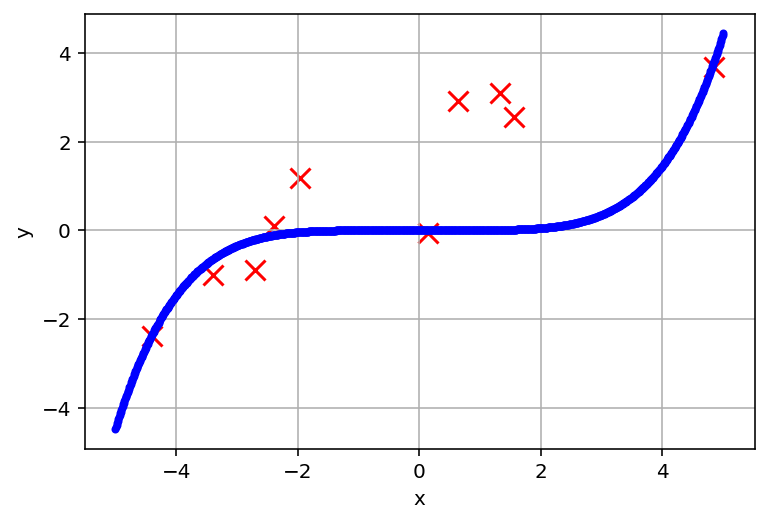

In [14]:
reg = SGDRegressor(batch=True, learning_rate=1e-7, max_iter=100, c_lambda=1000, penalty='l2')
reg.fit(x_all_feat[sub_train], y_all[sub_train])
y_pred = reg.predict(x_all_feat)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')
y_test_pred = reg.predict(x_all_feat[test_indices])
test_mse = mse(y_pred=y_test_pred, y_true=y_all[test_indices])
print('test rmse: %.4f' % np.sqrt(test_mse));